<div style="align: center;">
    <br>
    <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/38321/logos/header.png?t=2022-08-23-05-06-07" style="display:block; margin:auto; width:95%; height:250px;">
</div><br><br> 

<div style="letter-spacing:normal; opacity:1.;">
<!--   https://xkcd.com/color/rgb/   -->
  <p style="text-align:center; background-color: lightsalmon; color: Jaguar; border-radius:10px; font-family:monospace; 
            line-height:1.4; font-size:32px; font-weight:bold; text-transform: uppercase; padding: 9px;">
            <strong>Feedback Prize - English Language Learning</strong></p>  
  
  <p style="text-align:center; background-color:romance; color: Jaguar; border-radius:10px; font-family:monospace; 
            line-height:1.0; font-size:28px; font-weight:normal; text-transform: capitalize; padding: 5px;"
     >Deep Learning Module: <a href='https://huggingface.co/bert-large-uncased'>"HuggingFace BERT Model"</a> Classification<br>(Multi-Label and Multi-Class)</p>    
</div>

**Dataset Info**

<a href='https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview'>Click for More Details:</a> 

The dataset presented here (the ELLIPSE corpus) comprises argumentative essays written by 8th-12th grade English Language Learners (ELLs). The essays have been scored according to six analytic measures: **cohesion, syntax, vocabulary, phraseology, grammar, and conventions.**

Each measure represents a component of proficiency in essay writing, with greater scores corresponding to greater proficiency in that measure. <span style="background-color:LightGray; color:Black;">The scores range from 1.0 to 5.0 in increments of 0.5. Your **TASK** is to predict the score of each of the six measures for the essays given in the test set.</span>

Some of these essays have appeared in the datasets for the **Feedback Prize - Evaluating Student Writing** and **Feedback Prize - Predicting Effective Arguments** competitions. You are welcome to make use of these earlier datasets in this competition.

**File and Field Information**

**train.csv** - The training set, comprising the full_text of each essay, identified by a unique text_id. The essays are also given a score for each of the seven analytic measures above: cohesion, etc. These analytic measures comprise the target for the competition.

**test.csv** - For the test data we give only the full_text of an essay together with its text_id.

**sample_submission.csv** - A submission file in the correct format. See the Evaluation page for details.

- Dataset: https://www.kaggle.com/competitions/feedback-prize-english-language-learning

# Import Libraries & Ingest Data

## Kaggle/Colab Update

⚠️ **need to restart**

In [1]:
%%writefile requirements.txt
transformers                # Hugging Face Library
matplotlib==3.5.3
plotly==5.11.0
tensorflow-addons==0.19.0   # https://github.com/tensorflow/addons#python-op-compatility

Overwriting requirements.txt


In [2]:
import sys, platform
print("Python  :", sys.version)
print("Platform:", platform.platform())

!{sys.executable} -m pip install -Uq -r requirements.txt

Python  : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
Platform: Linux-5.15.90+-x86_64-with-debian-bullseye-sid


## Print Available Devices - 'TPU', 'GPU', 'CPU'.

In [3]:
import tensorflow as tf
print("Tensorflow version \t\t:" + tf.__version__)

# print("Available devices:")
# for i, device in enumerate(tf.config.list_logical_devices()):
#     print("%d) %s" % (i, device))

# check if tensorflow see the GPU
# tf.test.gpu_device_name()

print("Num physical_GPUs Available\t:", len(tf.config.list_physical_devices('GPU')))
print("Num physical_CPUs Available\t:", len(tf.config.list_physical_devices('CPU')))
print()
print("Num logical_GPUs Available\t:", len(tf.config.list_logical_devices('GPU')))
print("Num logical_CPUs Available\t:", len(tf.config.list_logical_devices('CPU')))

Tensorflow version 		:2.11.0
Num physical_GPUs Available	: 0
Num physical_CPUs Available	: 1

Num logical_GPUs Available	: 0
Num logical_CPUs Available	: 1


## TPU, GPU or CPU Detection

In [4]:
try:
    import tensorflow as tf
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # tf.config.experimental_connect_to_cluster(resolver)
    # tf.tpu.experimental.initialize_tpu_system(resolver)
    # strategy = tf.distribute.TPUStrategy(resolver)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)    
    print('Running on TPU ', tpu.master(), len(tf.config.list_logical_devices('TPU')))
    gpus = None
    
except ValueError:
    # If there's a GPU avaiable, to use the GPU, otherwise, using the CPU instead.
    gpus = tf.config.list_logical_devices('GPU')
    if len(gpus) > 1:        
        strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])           
        print('Running on multiple GPUs ', gpus)  
    elif len(gpus) == 1:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on single GPU ', gpus[0].name)
    else:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on CPU')
        
print("Number of accelerators: ", strategy.num_replicas_in_sync)    
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

Running on TPU  grpc://10.0.0.2:8470 8
Number of accelerators:  8


In [5]:
# for kaggle "GPU" shard warning during model fitting
import tensorflow.python as tf_python

if gpus:
    print("changed shard policy...")
    tf.data.experimental.DistributeOptions.auto_shard_policy = tf_python.data.util.options.create_option(
        docstring="The type of sharding to use. See "
        "`tf.data.experimental.AutoShardPolicy` for additional information.",
        ty=tf.data.experimental.AutoShardPolicy,
        default_factory=lambda: tf.data.experimental.AutoShardPolicy.DATA,
        name="auto_shard_policy",
    )
    
# # way-2
# if isinstance(strategy, tf.distribute.MirroredStrategy): 
#     # Shard Policy for GPU
#     options = tf.data.Options()
#     options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE    
#     train_ds = train_ds.with_options(options)
#     print('Apply Shard Policy for GPU')

## Importing Related Libraries

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# !pip3 install plotly==5.11.0
import plotly
import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as stats

## Parameters

In [8]:
MAX_TOKEN_COUNT = 512

# Recognizing And Understanding Data

In [9]:
train_df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
sample_submission_df = pd.read_csv('../input/feedback-prize-english-language-learning/sample_submission.csv')

train_df.shape, test_df.shape, sample_submission_df.shape

((3911, 8), (3, 2), (3, 7))

In [10]:
display(train_df, test_df, sample_submission_df)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [11]:
display(train_df.info(), test_df.info(), sample_submission_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_id    3 non-null      object
 1   full_text  3 non-null      object
dtypes: object(2)
memory usage: 176.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column       N

None

None

None

## Check the statistical values of features.

In [12]:
train_df.describe(include='O').T

,count,unique,top,freq
text_id,3911,3911,0016926B079C,1
full_text,3911,3911,I think that students would benefit from learn...,1


In [13]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.0,3.127077,0.662542,1.0,2.5,3.0,3.5,5.0
syntax,3911.0,3.028254,0.644399,1.0,2.5,3.0,3.5,5.0
vocabulary,3911.0,3.235745,0.583148,1.0,3.0,3.0,3.5,5.0
phraseology,3911.0,3.116850,0.655997,1.0,2.5,3.0,3.5,5.0
grammar,3911.0,3.032856,0.699841,1.0,2.5,3.0,3.5,5.0
conventions,3911.0,3.081053,0.671450,1.0,2.5,3.0,3.5,5.0


In [14]:
train_df.select_dtypes('number').apply(pd.Series.value_counts).T

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
cohesion,10,27,315,790,1096,988,534,125,26
syntax,11,29,410,839,1250,867,388,100,17
vocabulary,2,14,124,528,1503,1007,577,115,41
phraseology,10,11,350,772,1153,929,553,108,25
grammar,8,20,544,855,994,880,447,134,29
conventions,15,20,402,784,1151,908,484,122,25


In [15]:
train_df.select_dtypes('number').nunique()

cohesion       9
syntax         9
vocabulary     9
phraseology    9
grammar        9
conventions    9
dtype: int64

## Basically check the missing values

In [16]:
train_df.duplicated().sum()

0

In [17]:
train_df.isna().sum()

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
dtype: int64

In [18]:
train_df.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')

# EDA and Graphical analysis

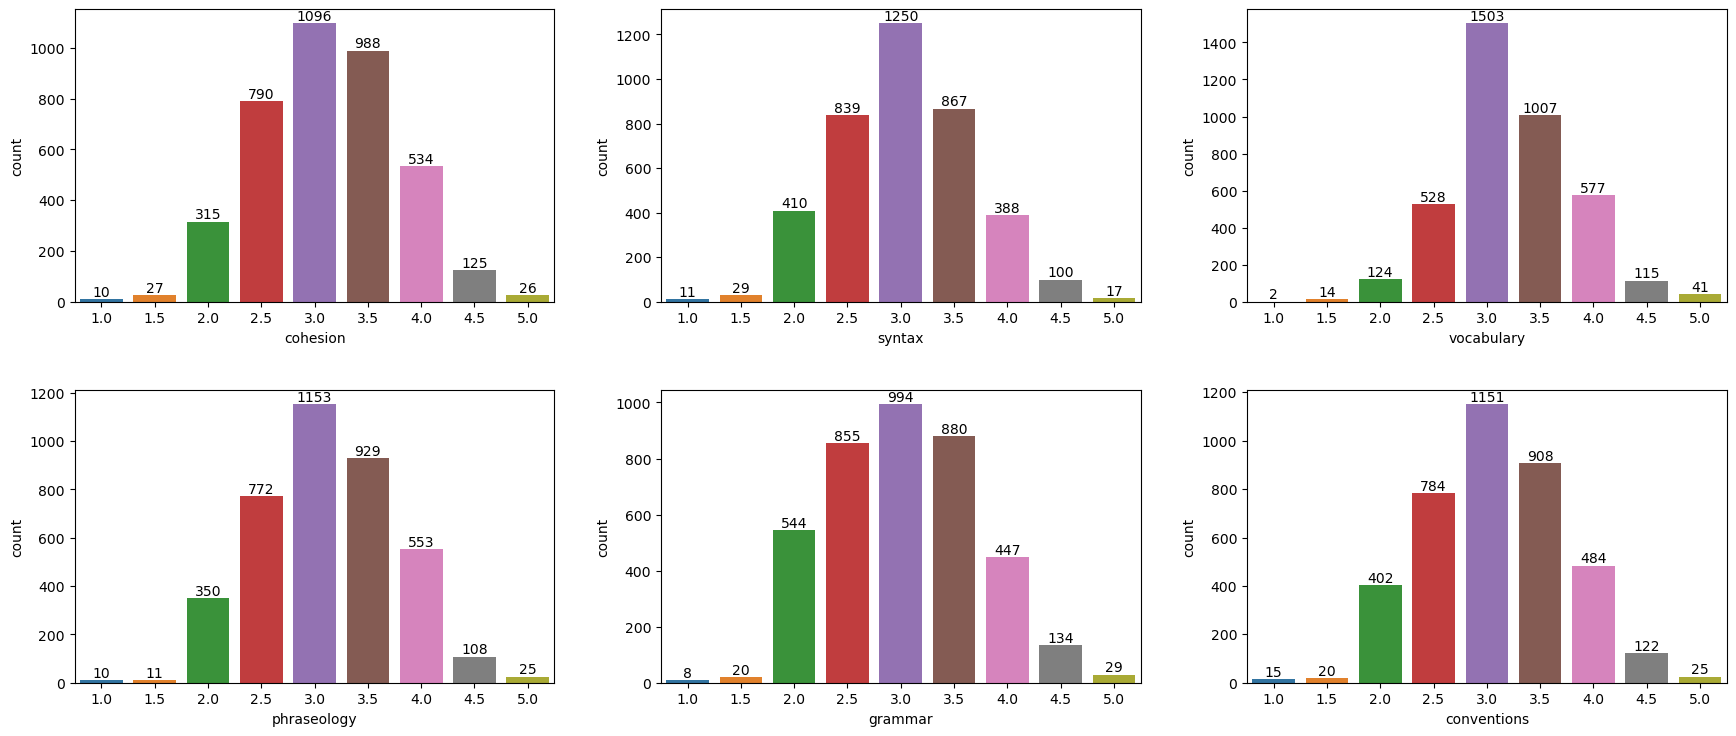

In [19]:
numbers = train_df.select_dtypes('number').columns

fig = plt.figure(figsize=(18, 8))
for i, col in enumerate(numbers):
    ax = plt.subplot(int(np.ceil(len(numbers)/3)), 3, i+1)
    sns.countplot(data = train_df, x = col, palette = [f'C{i}' for i in range(10)], ax=ax)
    ax.bar_label(ax.containers[0])
    plt.tight_layout(pad=3)

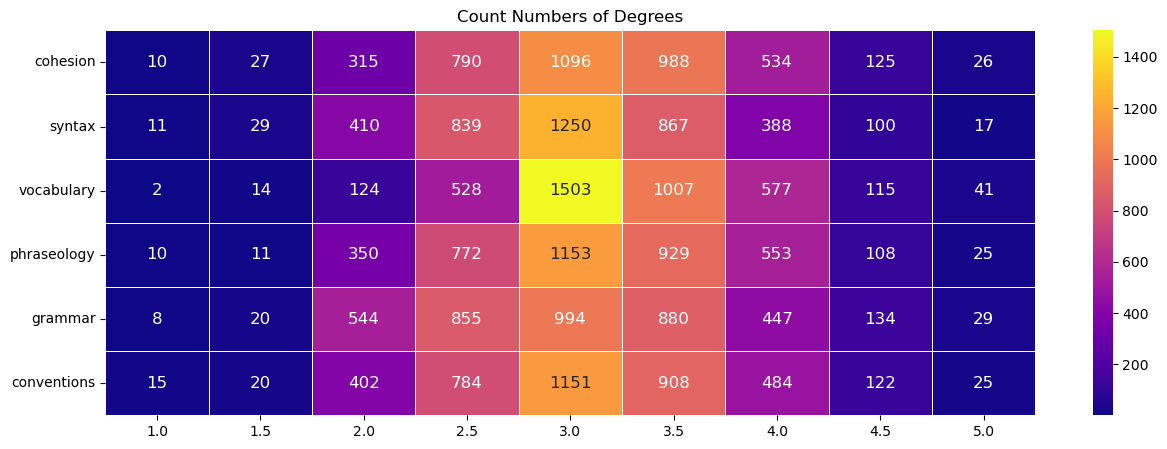

In [20]:
fig = plt.figure(figsize=(15, 5))
sns.heatmap(
    data = train_df.select_dtypes('number').apply(pd.Series.value_counts).T, 
    annot=True, annot_kws={'fontsize':12},
    fmt = '.0f', cmap = 'plasma',
    lw=.5,
)
plt.yticks(rotation=0)
plt.title('Count Numbers of Degrees');

In [21]:
fig = px.imshow(
    train_df.select_dtypes('number').apply(pd.Series.value_counts).T,
    aspect="auto", text_auto=True, 
    color_continuous_scale = 'plasma'
)
# Set figure title
fig.update_layout(title_text="Count Numbers of Degrees")
fig.show()

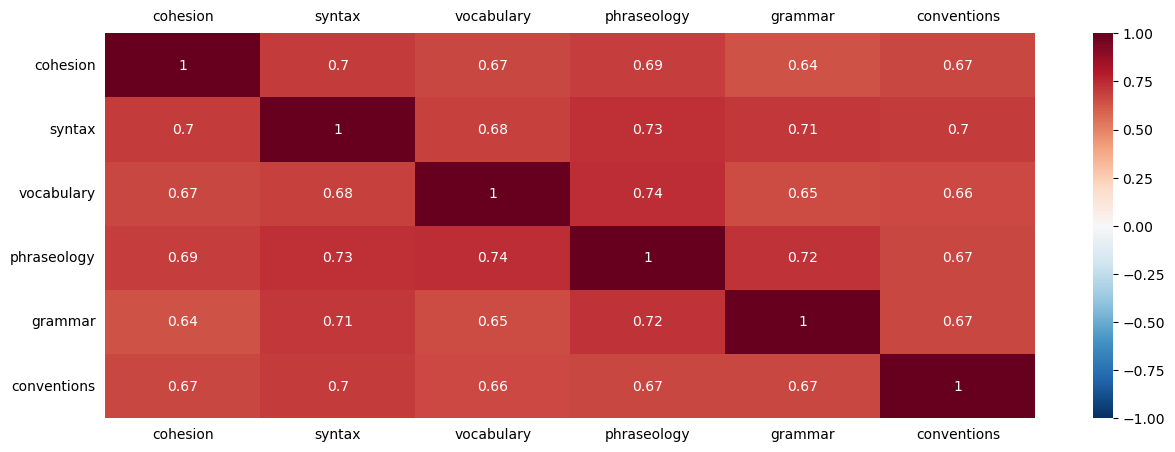

In [22]:
fig = plt.figure(figsize=(15, 5))

sns.heatmap(
    train_df[numbers].corr().round(2), 
    vmin=-1, vmax=1, annot=True, 
    cmap = 'RdBu_r'
)
plt.tick_params(bottom=False, left=False)
plt.tick_params(top=False, left=False)
plt.tick_params(labeltop=True)

In [23]:
fig = px.imshow(
    train_df[numbers].corr().round(2), 
    zmin=-1, zmax=1, text_auto=True, 
    color_continuous_scale = 'RdBu_r',
    aspect="auto", 
)
fig.update_xaxes(side="top")
fig.show()

## Examine Text

In [24]:
sample_df = train_df.copy()
sample = sample_df.sample(frac=1, random_state=101).head()
sample

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
3335,E71EFBE547CF,Everyone has a talent or skill. Everyone can d...,3.5,4.0,4.0,3.5,4.0,3.5
2679,C5FF203DE2DE,I used my sowing to help me with having a choi...,3.5,3.0,3.0,3.5,3.5,3.0
3319,E5B3346016BA,A POSITIVE ATTITUDE IS THE KEY IN\n\nLIFE\n\nA...,3.5,3.5,3.5,3.0,3.0,3.0
1867,8C83ACEF2A15,I agree that some district offer programs that...,3.5,3.5,3.5,3.0,3.5,4.0
379,1CF3776F970D,"Dear principal,\r\n\r\nWell its important to h...",3.5,2.5,3.5,3.0,3.0,3.5


In [25]:
sample_df['total_score'] = train_df[numbers].sum(axis=1)
lowest_df = sample_df.sort_values('total_score').head(9)
lowest_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,total_score
1540,767533E12569,he is a good because they are the prescient an...,1.0,1.0,1.0,1.0,1.0,1.0,6.0
952,48EA282A4EAF,some student offer distance learning as an opt...,1.0,1.0,1.0,1.0,1.0,1.0,6.0
3086,DB2EA5C4828F,"Technology is positive, because is the good po...",1.0,1.0,1.5,1.0,1.0,1.0,6.5
3679,F69C85F4C3CA,the memorable teacher ever had\r\n\r\nwas a te...,1.0,1.0,1.5,1.0,1.0,1.5,7.0
514,2716F5E20A4F,"The students be required to take music ,drama ...",1.5,1.0,1.5,1.0,1.0,1.5,7.5
1528,75A20F93C2C4,i like to work with a group a cash if you work...,1.5,1.5,1.5,1.0,1.0,1.0,7.5
934,4751F39ECBC5,thi don't really select a work in wat iam inte...,1.5,1.5,1.5,1.0,1.5,1.0,8.0
378,1CE5DBCEF2CE,allow students to bring phones to school and w...,1.5,1.5,1.5,1.0,2.0,1.0,8.5
39,03844422EA75,my name is Generic_Name and my story is about ...,1.0,1.0,2.0,2.0,1.5,1.0,8.5


In [26]:
sample_df['total_score'] = train_df[numbers].sum(axis=1)
highest_df = sample_df.sort_values('total_score', ascending=False).head(9)
highest_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,total_score
2389,B1AFACE6704E,I agree with Michelangelo's statement as I hav...,5.0,5.0,5.0,5.0,5.0,5.0,30.0
1082,52DC3B7C3952,Working From Home\n\nShould students be allowe...,5.0,5.0,4.5,5.0,5.0,5.0,29.5
258,12E3D52345C6,Technology has always acted as a compelling an...,5.0,5.0,5.0,5.0,4.5,5.0,29.5
1060,5132328226C2,Afterschool Homework Club\n\nMost students do ...,5.0,5.0,5.0,5.0,4.5,4.5,29.0
3445,EC2758A5B74E,"Dear School board,\n\nWhy does a student's edu...",5.0,5.0,4.5,5.0,5.0,4.5,29.0
1765,85C54BD4D416,"Thomas Jefferson, writer of the Declaration of...",4.5,5.0,5.0,4.5,5.0,5.0,29.0
104,07CE77EA56C5,Students work hard there is no arguing that. T...,5.0,5.0,5.0,5.0,4.5,4.5,29.0
937,477B00F899E2,Student-designed Projects Encourage Learning\n...,4.5,4.5,5.0,5.0,5.0,5.0,29.0
1206,5D7D1445A7CF,Smooth Sails do not make Skillful Sailors!\n\n...,4.5,5.0,5.0,5.0,4.5,4.5,28.5


# Bert Model Classification Multi-Label and Multi-Class

- https://machinelearningmastery.com/multi-label-classification-with-deep-learning/
- https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/
- https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

## Import Libraries

In [27]:
# !pip install transformers -Uq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoConfig
from transformers import pipeline
from wordcloud import WordCloud

# !pip install tensorflow -Uq
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

# !pip install scikeras[tensorflow] -Uq
# from scikeras.wrappers import KerasClassifier, KerasRegressor

## Train - Test Split

In [134]:
X = train_df['full_text'].values
y = train_df[numbers].values

X_test  = test_df['full_text'].values

X.shape, y.shape, X_test.shape

((3911,), (3911, 6), (3,))

In [135]:
!pip install iterative-stratification -q
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

mskf = MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=101)

for train_index, test_index in mskf.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    
X_train.shape, y_train.shape, X_val.shape, y_val.shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


((3259,), (3259, 6), (652,), (652, 6))

### Option 1: Apply LabelBinarizer to Each Label

In [136]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder

le = LabelEncoder()

Y_train = pd.DataFrame()
Y_val   = pd.DataFrame()

for i, col in enumerate(numbers):
    Y_train[i] = le.fit_transform(y_train[:, i])
    Y_val[i]   = le.transform(y_val[:, i])

Y_train = Y_train.values
Y_val   = Y_val.values

Y_train.shape, Y_val.shape,

((3259, 6), (652, 6))

In [137]:
lb = LabelBinarizer()

Y_train_cohesion    = lb.fit_transform(Y_train[:, 0])
Y_val_cohesion      = lb.transform(Y_val[:, 0])

Y_train_syntax      = lb.fit_transform(Y_train[:, 1])
Y_val_syntax        = lb.transform(Y_val[:, 1])

Y_train_vocabulary  = lb.fit_transform(Y_train[:, 2])
Y_val_vocabulary    = lb.transform(Y_val[:, 2])

Y_train_phraseology = lb.fit_transform(Y_train[:, 3])
Y_val_phraseology   = lb.transform(Y_val[:, 3])

Y_train_grammar     = lb.fit_transform(Y_train[:, 4])
Y_val_grammar       = lb.transform(Y_val[:, 4])

Y_train_conventions = lb.fit_transform(Y_train[:, 5])
Y_val_conventions   = lb.transform(Y_val[:, 5])
    
Y_train = np.hstack([Y_train_cohesion, Y_train_syntax, Y_train_vocabulary, Y_train_phraseology, Y_train_grammar, Y_train_conventions]).reshape(-1, 6, 9)
Y_val   = np.hstack([Y_val_cohesion, Y_val_syntax, Y_val_vocabulary, Y_val_phraseology, Y_val_grammar, Y_val_conventions]).reshape(-1, 6, 9)

Y_train.shape, Y_val.shape,

((3259, 6, 9), (652, 6, 9))

In [138]:
print(y_train[0], Y_train[0], sep='\n\n')

[3.5 3.5 3.  3.  4.  3. ]

[[0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0]]


### Option 2: Apply MultiLabelBinarizer (not implemented)

In [139]:
# way-2
# for MultiLabel-MultiClass uniqness - MultiLabelBinarizer
current_y = pd.DataFrame()
for i in numbers:
    current_y[i] = train_df[i].apply(lambda x: f'{i} {x}')
    
display(current_y)
current_y = current_y.values

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,cohesion 3.5,syntax 3.5,vocabulary 3.0,phraseology 3.0,grammar 4.0,conventions 3.0
1,cohesion 2.5,syntax 2.5,vocabulary 3.0,phraseology 2.0,grammar 2.0,conventions 2.5
2,cohesion 3.0,syntax 3.5,vocabulary 3.0,phraseology 3.0,grammar 3.0,conventions 2.5
3,cohesion 4.5,syntax 4.5,vocabulary 4.5,phraseology 4.5,grammar 4.0,conventions 5.0
4,cohesion 2.5,syntax 3.0,vocabulary 3.0,phraseology 3.0,grammar 2.5,conventions 2.5
...,...,...,...,...,...,...
3906,cohesion 2.5,syntax 3.0,vocabulary 3.0,phraseology 3.5,grammar 2.5,conventions 2.5
3907,cohesion 4.0,syntax 4.0,vocabulary 4.0,phraseology 4.0,grammar 3.5,conventions 3.0
3908,cohesion 2.5,syntax 3.0,vocabulary 3.0,phraseology 3.0,grammar 3.5,conventions 3.0
3909,cohesion 4.0,syntax 4.5,vocabulary 4.5,phraseology 4.0,grammar 4.5,conventions 4.5


In [140]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
# Create MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# One-hot encode data
current_Y_train = mlb.fit_transform(current_y)

current_Y_train[:1], current_Y_train.shape, 

(array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]),
 (3911, 54))

## Text Overview

### Simply Check Each Text Word Count

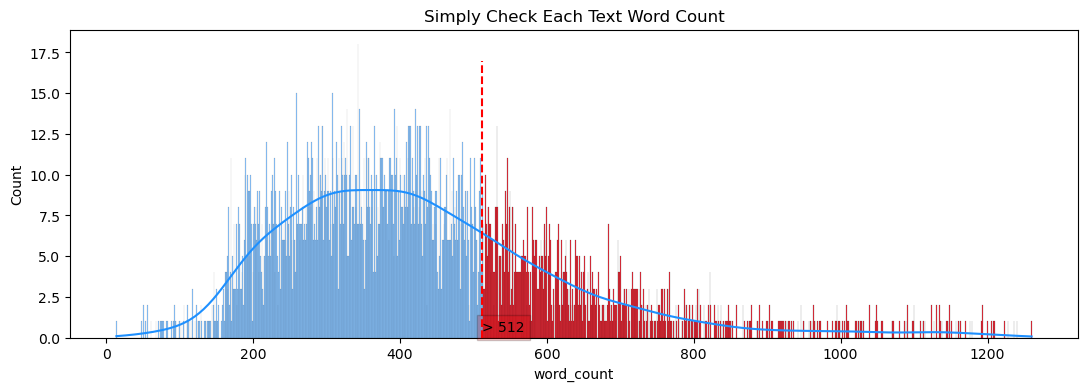

In [141]:
fig = plt.figure(figsize=(13, 4))
sample_df['word_count'] = train_df.full_text.apply(lambda x: len(x.split()))

sns.histplot(data=sample_df, x="word_count", stat='count', discrete=True, kde=True, color='dodgerblue')
sns.histplot(data=sample_df[sample_df.word_count > 512], x="word_count", stat='count', discrete=True, color='r')
plt.vlines(512, 0, 17, linestyles ="dashed", colors ="r")
plt.text(512, 0.2, '> 512', ha='left', va='bottom',rotation='horizontal', 
         fontsize=10, backgroundcolor='white', bbox=dict(facecolor='red', alpha=0.2))
plt.title("Simply Check Each Text Word Count");

## Build Image with WordCloud

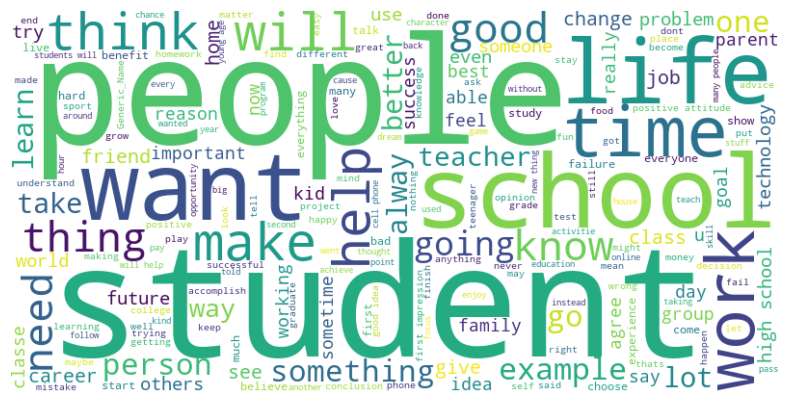

In [142]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color='white', 
    width=800, height=400).generate(' '.join(train_df['full_text']))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## Apply Tokenization and Detailed Check Each Text Word Count

In [143]:
from transformers import AutoTokenizer

# bert cased or uncased
# model_name = "bert-base-uncased"
# model_name = "albert-xxlarge-v2"
model_name = "bert-large-uncased"
# model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"

tokenizer  = AutoTokenizer.from_pretrained(model_name)

In [144]:
max_token = []

for sent in X_train:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.    
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_token.append(len(input_ids))

print('Max sentence length: ', max(max_token))

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1435


In [145]:
arr = np.array(max_token)
 
print("Descriptive analysis")
print("Document Size \t=", arr.shape[0])
print("Doc Token Count\t=", arr)
print()
# measures of central tendency
print("Measures of Central Tendency")
print("Mean \t\t=", arr.mean())
print("Median \t\t=", np.median(arr))
print("Mode \t\t=", stats.mode(arr)[0][0])
print()
# measures of dispersion
print("Measures of Dispersion")
print("Minimum \t=", arr.min())
print("Maximum \t=", arr.max())
print("Range \t\t=", arr.ptp())
print("Variance \t=", arr.var())
print("Standard Deviation =", arr.std())

Descriptive analysis
Document Size 	= 3259
Doc Token Count	= [293 567 373 ... 302 580 699]

Measures of Central Tendency
Mean 		= 491.2982509972384
Median 		= 458.0
Mode 		= 458

Measures of Dispersion
Minimum 	= 16
Maximum 	= 1435
Range 		= 1419
Variance 	= 47307.84169991736
Standard Deviation = 217.5036590494913


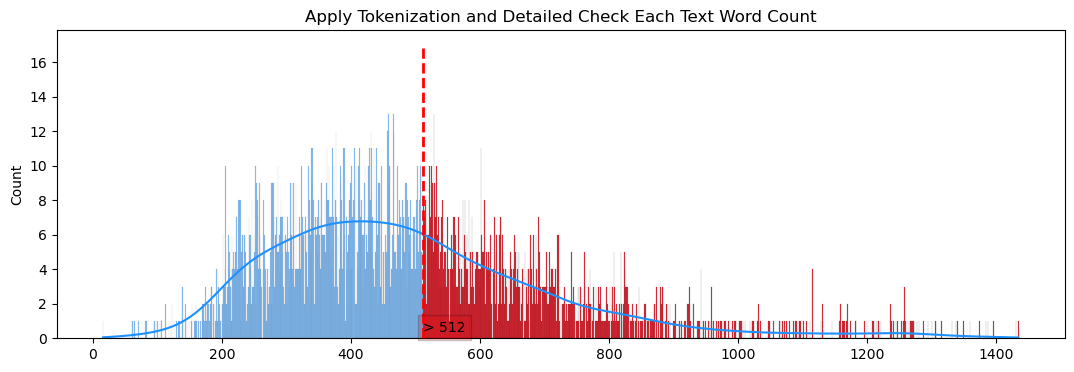

In [146]:
plt.figure(figsize=(13, 4))
sns.histplot(x=max_token, stat='count', discrete=True, kde=True, color='dodgerblue')
sns.histplot(x=pd.Series(max_token)[pd.Series(max_token) > 512], stat='count', discrete=True, color='r')
plt.vlines(x=512, ymin=0, ymax=17, colors ="r", ls ="dashed", lw=2)
plt.text(512, 0.2, '> 512', ha='left', va='bottom',rotation='horizontal', 
         fontsize=10, backgroundcolor='white', bbox=dict(facecolor='red', alpha=0.2))
plt.title("Apply Tokenization and Detailed Check Each Text Word Count");

In [147]:
round(sum(np.array(max_token) < MAX_TOKEN_COUNT) / len(max_token), ndigits=2)

0.61

In [148]:
seq_len = MAX_TOKEN_COUNT

## Examine One Sample Text

![](https://techcommunity.microsoft.com/t5/image/serverpage/image-id/168851i1E57535F0A5D6BF6/image-dimensions/2000?v=v2&px=-1)

In [149]:
text = 'This is example text. 😊'
tokenizer.tokenize(text)

['this', 'is', 'example', 'text', '.', '[UNK]']

In [150]:
tokenizer.encode(text, add_special_tokens=True, return_tensors='np')

array([[ 101, 2023, 2003, 2742, 3793, 1012,  100,  102]])

In [151]:
tokenizer.decode([101, 2023, 2003, 2742, 3793, 1012, 100, 102], add_special_tokens=True)

'[CLS] this is example text. [UNK] [SEP]'

In [152]:
print(tokenizer.tokenize(text, padding="max_length", truncation=True, max_length=seq_len))

['this', 'is', 'example', 'text', '.', '[UNK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [153]:
tokenizer(text, padding="max_length", truncation=True, max_length=seq_len)

{'input_ids': [101, 2023, 2003, 2742, 3793, 1012, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Transformation text to TENSOR

### Transformation Vectors to Matrices

In [154]:
labels_train = Y_train#.reshape(-1, 1)
labels_val   = Y_val#.reshape(-1, 1)

labels_train.shape, labels_val.shape

((3259, 6, 9), (652, 6, 9))

In [155]:
def transformation(X, seq_len):
    # initialize empty zero arrays
    Xids  = np.zeros((len(X), seq_len))
    Xmask = np.zeros((len(X), seq_len))

    for i, phrase in enumerate(X):
        tokens = tokenizer.encode_plus(
            phrase, 
            max_length = seq_len, 
            padding = 'max_length',
            truncation = True, 
            add_special_tokens=True,
            return_attention_mask = True,
        ) 
        # assign tokenized outputs to respective rows in numpy arrays
        Xids[i]  = tokens['input_ids']
        Xmask[i] = tokens['attention_mask']
    return Xids, Xmask

Xids_train, Xmask_train = transformation(X_train, seq_len)
Xids_val,   Xmask_val   = transformation(X_val, seq_len)
Xids_test,  Xmask_test  = transformation(X_test, seq_len)

print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print()
print("Xids_val.shape    :", Xids_val.shape)
print("Xmask_val.shape   :", Xmask_val.shape)
print()
print("Xids_test.shape   :", Xids_test.shape)
print("Xmask_test.shape  :", Xmask_test.shape)

Xids_train.shape  : (3259, 512)
Xmask_train.shape : (3259, 512)

Xids_val.shape    : (652, 512)
Xmask_val.shape   : (652, 512)

Xids_test.shape   : (3, 512)
Xmask_test.shape  : (3, 512)


### Transformation Matrix to Tensor

In [156]:
dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_val   = tf.data.Dataset.from_tensor_slices((Xids_val,   Xmask_val,   labels_val))
dataset_test  = tf.data.Dataset.from_tensor_slices((Xids_test,  Xmask_test))

dataset_train, dataset_val, dataset_test

(<TensorSliceDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(6, 9), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(6, 9), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None))>)

In [157]:
def map_func(Xids, Xmask, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask}, labels 

def map_func_no_label(Xids, Xmask):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask} 

# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_val   = dataset_val.map(map_func)
dataset_test  = dataset_test.map(map_func_no_label)

dataset_train, dataset_val, dataset_test

(<MapDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6, 9), dtype=tf.int64, name=None))>,
 <MapDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6, 9), dtype=tf.int64, name=None))>,
 <MapDataset element_spec={'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}>)

### Batch Size

In [158]:
# it's important, if raise error memory size reduce batch size
batch_size = 16 # 16, 32

train_ds = dataset_train.batch(batch_size) # Using for metrics calculations
val_ds   = dataset_val.batch(batch_size)
test_ds  = dataset_test.batch(batch_size)

train_ds2 = dataset_train.shuffle(buffer_size = len(X_train), reshuffle_each_iteration=True).batch(batch_size) 

### Creating Model

- https://github.com/keras-team/keras/blob/2ad932ba4ea501af7c3163573fce994ef878d8ef/keras/metrics.py#L30

In [175]:
print(f'Model Name:\t{model_name}', f'\nSentence Len:\t{seq_len}')

# way-1
def build_classifier_model(
    model_name: str = model_name,
    seq_length: int = seq_len,
) -> tf.keras.models.Model:      
    import tensorflow as tf    
    from transformers import TFAutoModel, AutoModel, AutoConfig    
    
    # Download model and configuration from huggingface.co and cache.
    model          = TFAutoModel.from_pretrained(model_name)
    
    # Two inputs
    input_ids      = tf.keras.layers.Input(shape=(seq_length, ), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(seq_length, ), dtype=tf.int32, name='attention_mask')
    
    # Transformer
    embeddings = model.__call__(input_ids=input_ids, attention_mask=attention_mask)[1]  #for bert ["pooler_output"] 
#     embeddings = model.__call__(input_ids=input_ids, attention_mask = attention_mask)[0]  #use __call__ or model name = deberta  
    
    # Classifier head
    x = tf.keras.layers.Dense(seq_length, activation='selu', 
                              kernel_initializer='he_uniform', kernel_regularizer='l1_l2')(embeddings) # 
#     x = tf.keras.layers.BatchNormalization()(embeddings)
    x = tf.keras.layers.Dropout(0.5)(x)  # 0.1
    
    # Reshape bert_output before passing it the GRU-LSTM
    x = tf.keras.layers.Reshape((1,) + x.shape[1:])(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Bidirectional - LSTM
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(seq_length, activation='selu', 
                                                           dropout=0.5, recurrent_dropout=0.5, return_sequences=True))(x)
    # Bidirectional - GRU
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(seq_length, activation='selu', 
                                                           dropout=0.5, recurrent_dropout=0.5, return_sequences=True))(x)
    
    # Dense cohesion
    y1 = tf.keras.layers.Dense(9, activation = tf.nn.softmax, name='cohesion')(x) 
    # Dense syntax
    y2 = tf.keras.layers.Dense(9, activation = tf.nn.softmax, name='syntax')(x) 
    # Dense vocabulary
    y3 = tf.keras.layers.Dense(9, activation = tf.nn.softmax, name='vocabulary')(x) 
    # Dense phraseology
    y4 = tf.keras.layers.Dense(9, activation = tf.nn.softmax, name='phraseology')(x) 
    # Dense grammar
    y5 = tf.keras.layers.Dense(9, activation = tf.nn.softmax, name='grammar')(x) 
    # Dense conventions
    y6 = tf.keras.layers.Dense(9, activation = tf.nn.softmax, name='conventions')(x)    
    
    model  = tf.keras.Model(inputs = [input_ids, attention_mask], 
                            outputs = tf.reshape(tf.concat([y1, y2, y3, y4, y5, y6], 1), [-1, 6, 9]), 
                            name=f'{model_name}>BERT_MultiLabel_MultiClass')    
    
    # precision_at_recall = tf.keras.metrics.PrecisionAtRecall(recall=0.8)
    # accuracy = tf.keras.metrics.BinaryAccuracy()
    # precision = tf.keras.metrics.Precision()
    # auc = tf.keras.metrics.AUC()  
    
    def tf_f1_score(y_true, y_pred):
        # y_pred = tf.math.sigmoid(y_pred)
        true_positives      = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives  = K.sum(K.round(K.clip(y_true, 0, 1)))        
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        
        precision_keras = true_positives / (predicted_positives + K.epsilon())
        recall_keras    = true_positives / (possible_positives + K.epsilon())
        f1_score        = (2*precision_keras*recall_keras) / (precision_keras+recall_keras+K.epsilon())
        return f1_score
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005), # tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0),  
                  loss      = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics   = ['Recall', tf_f1_score, 'categorical_accuracy'], 
                  # weighted_metrics = [tf.keras.metrics.Recall()] 
    )
    return model

Model Name:	bert-large-uncased 
Sentence Len:	512


In [176]:
tf.keras.backend.clear_session()

with strategy.scope():  
    model = build_classifier_model()
    model.summary()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "bert-large-uncased>BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,   

In [177]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode="min", 
                           verbose = 1, patience = 9, restore_best_weights=True)

In [178]:
%%time
history = model.fit(train_ds2, validation_data = val_ds, #validation_split = 0.2, 
                    batch_size = 8, epochs = 30, callbacks=[early_stop], verbose = 1)

Epoch 1/30
204/204 [==============================] - 244s 347ms/step - loss: 24.9603 - recall: 0.2873 - tf_f1_score: 0.2891 - categorical_accuracy: 0.2942 - val_loss: 15.3839 - val_recall: 0.2932 - val_tf_f1_score: 0.2914 - val_categorical_accuracy: 0.2932
Epoch 2/30
204/204 [==============================] - 44s 218ms/step - loss: 29.7085 - recall: 0.2763 - tf_f1_score: 0.2759 - categorical_accuracy: 0.2764 - val_loss: 54.3735 - val_recall: 0.2561 - val_tf_f1_score: 0.2546 - val_categorical_accuracy: 0.2561
Epoch 3/30
204/204 [==============================] - 44s 217ms/step - loss: 51.9524 - recall: 0.2624 - tf_f1_score: 0.2621 - categorical_accuracy: 0.2624 - val_loss: 45.6798 - val_recall: 0.2743 - val_tf_f1_score: 0.2726 - val_categorical_accuracy: 0.2743
Epoch 4/30
204/204 [==============================] - 48s 236ms/step - loss: 22.6739 - recall: 0.2642 - tf_f1_score: 0.2639 - categorical_accuracy: 0.2642 - val_loss: 13.5158 - val_recall: 0.2743 - val_tf_f1_score: 0.2726 - val_

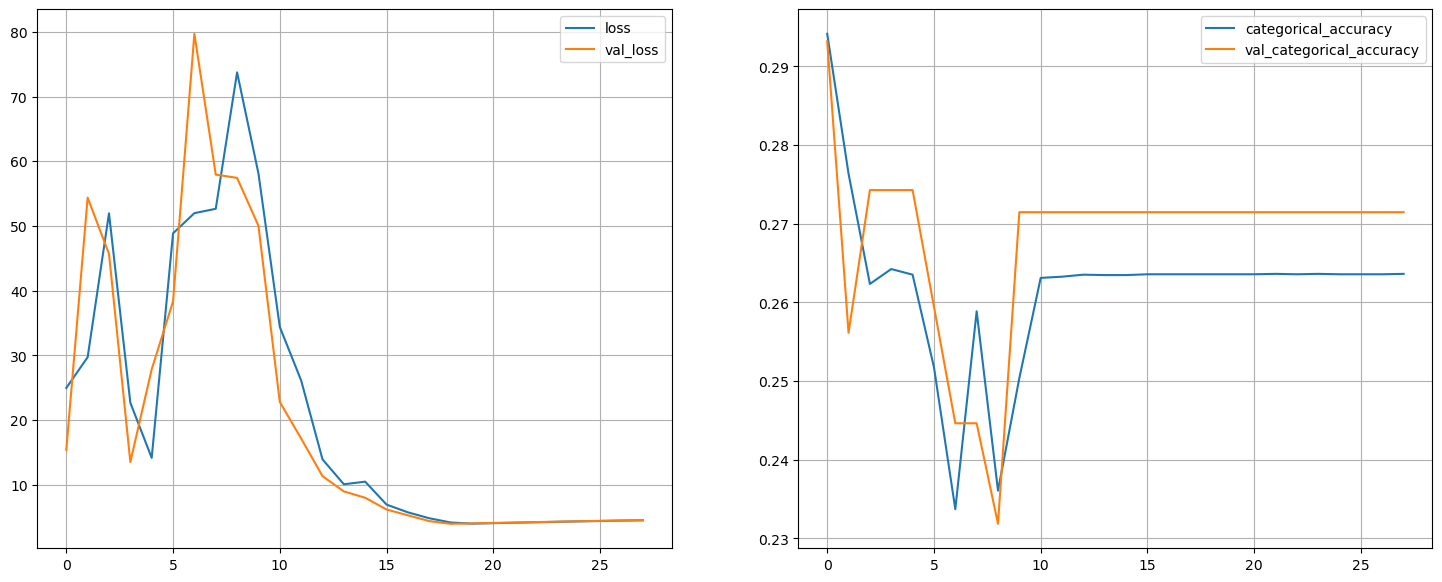

In [181]:
# Plot training results
H = history.history
fig = plt.figure(figsize = (18, 7))

plt.subplot(121)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['categorical_accuracy'], label = 'categorical_accuracy')
plt.plot(H['val_categorical_accuracy'], label = 'val_categorical_accuracy')
plt.grid()
plt.legend();

In [126]:
# model.evaluate(train_ds, return_dict=1)

In [180]:
y_pred_prob = model.predict(val_ds)
y_pred_prob[0]

41/41 [==============================] - 23s 353ms/step


array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [182]:
y_pred = np.array([le.inverse_transform(np.argmax(i, axis=1)) for i in y_pred_prob])
y_pred

array([[3. , 2.5, 3. , 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 3. ],
       ...,
       [3. , 2.5, 3. , 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 3. ]])

In [183]:
y_val

array([[3.5, 4. , 4. , 3.5, 3.5, 4. ],
       [3.5, 3. , 3.5, 3.5, 3.5, 4. ],
       [3. , 2.5, 2.5, 2.5, 2. , 2.5],
       ...,
       [3. , 3. , 3.5, 4. , 3.5, 3. ],
       [2. , 3. , 3. , 2.5, 2. , 2. ],
       [3. , 2.5, 3. , 2.5, 2.5, 3. ]])

In [184]:
from sklearn.metrics import classification_report

for i, col in enumerate(numbers):
    print('TARGET: ', col)
    print(classification_report(
        y_val[:, i].astype(str), y_pred[:, i].astype(str),
        labels=le.classes_
    ))

TARGET:  cohesion
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         0
         1.5       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00        52
         2.5       0.00      0.00      0.00       131
         3.0       0.29      1.00      0.45       188
         3.5       0.00      0.00      0.00       167
         4.0       0.00      0.00      0.00        83
         4.5       0.00      0.00      0.00        22
         5.0       0.00      0.00      0.00         2

   micro avg       0.29      0.29      0.29       652
   macro avg       0.03      0.11      0.05       652
weighted avg       0.08      0.29      0.13       652

TARGET:  syntax
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         1.5       0.00      0.00      0.00         4
         2.0       0.00      0.00      0.00        63
         2.5       0.22      1.00      0.37 

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise c

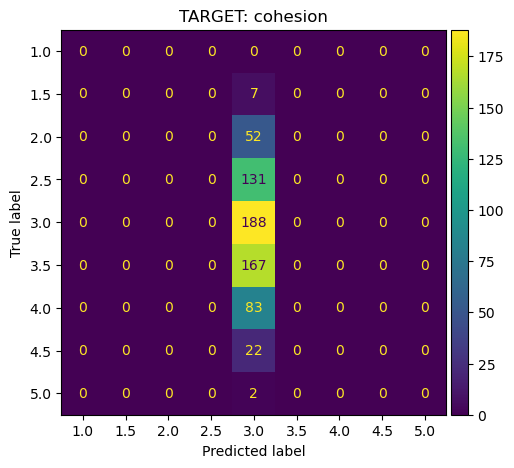

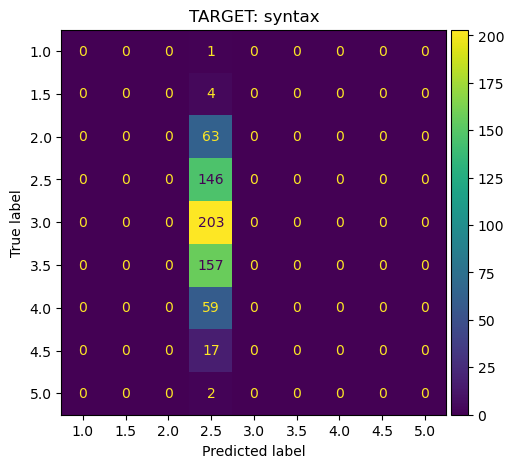

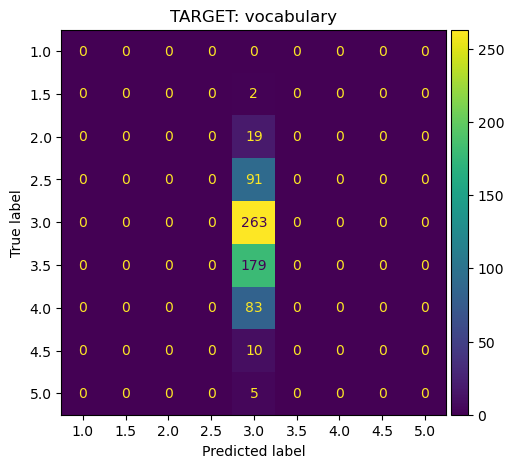

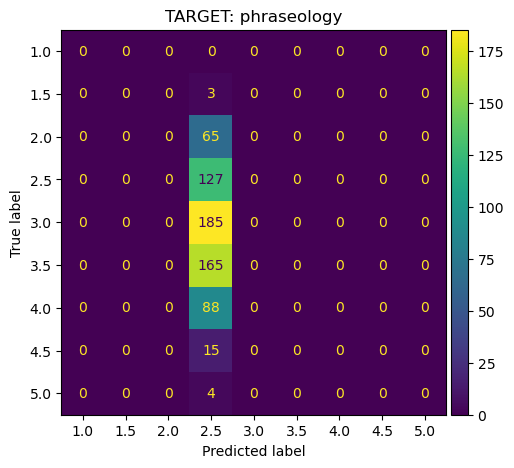

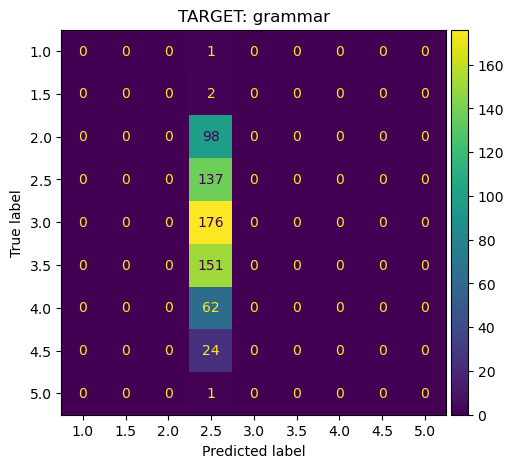

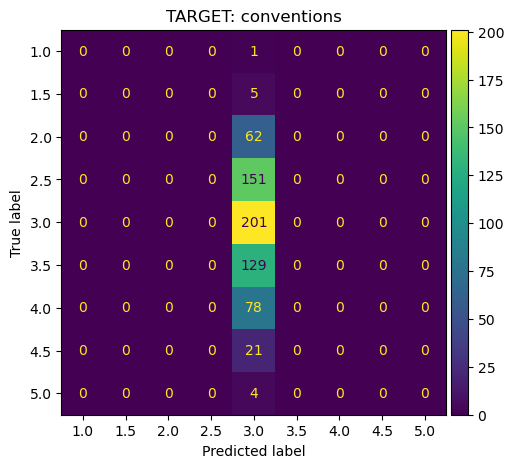

In [185]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

for i, col in enumerate(numbers):
    cm = confusion_matrix(
        y_val[:, i].astype(str), y_pred[:, i].astype(str),
        labels=le.classes_.astype(str)
    )

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(f'TARGET: {col}')
    
    cmp = ConfusionMatrixDisplay(
        confusion_matrix=cm, 
        display_labels=le.classes_.astype(str)
    )#.plot(ax=ax)

    # Deactivate default colorbar
    cmp.plot(ax=ax, colorbar=False)
    plt.grid(False)

    # Adding custom colorbar
    cax = fig.add_axes([ax.get_position().x1+.01, ax.get_position().y0, .033, ax.get_position().height])
    plt.colorbar(cmp.im_, cax=cax)

In [186]:
y_test_pred_prob = model.predict(test_ds)
y_test_pred_prob

1/1 [==============================] - 21s 21s/step


array([[[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.]]], dtype=float32)

In [187]:
y_test_pred = np.array([le.inverse_transform(np.argmax(i, axis=1)) for i in y_test_pred_prob])
y_test_pred

array([[3. , 2.5, 3. , 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 3. ]])

In [188]:
submission_df = sample_submission_df.copy()
submission_df[numbers] = y_test_pred
submission_df

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,2.5,3.0,2.5,2.5,3.0
1,000BAD50D026,3.0,2.5,3.0,2.5,2.5,3.0
2,00367BB2546B,3.0,2.5,3.0,2.5,2.5,3.0


## save submission

In [189]:
submission_df.to_csv("submission.csv", index=False)

## Download Link

In [190]:
from IPython.display import FileLink, FileLinks
local_file = FileLink(r'submission.csv', result_html_prefix="Click here to download: ")
local_file

/kaggle/working/submission.csv